# Supporting Jupyter Notebook

## Sigma Profiles in Deep Learning: Towards a Universal Molecular Descriptor

This supporting Jupyter Notebook illustrates some of the code developed throughout this work. It is divided in two sections. Section A allows the user to evaluate the performance of the convolutional neural networks developed. Section B allows the user to use the convolutional neural networks to make predictions on specific compounds included in the databases.

## Section A

This section allows the user to evaluate the performance of the CNNs developed in this work. To do so, the normalization weights for features and labels, as well as the tensorflow model, are loaded. Then, the entire sigma profile database available for the desired property is normalized and passed through the tensorflow model (CNN). The predictions obtained are unnormalized and compared against the experimental values.

Necessary imports:

In [1]:
# General
import os
import pickle

# Specific
import pandas
import numpy
import tensorflow
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt

# Local
from lib import mlAuxiliary as ml

Choose the database code to be evaluated (MM, BP, VP, D, RI, S, D_20, RI_20,S_25) and load the database:

In [2]:
# Database
code='MM' # Change here to MM, BP, VP, D, RI, S, D_20, RI_20, or S_25, as desired.
database=code+'_mlDatabase'
# Build databasePath and load database
databasePath=os.path.join('..','Databases',database+'.csv')
mlDatabase=pandas.read_csv(databasePath,dtype=str)

Check wether mlDatabase is of type 1 (no temperature input) or type 2 (temperature input):

In [3]:
if mlDatabase.shape[1]==56: CNN_type=1
elif mlDatabase.shape[1]==57: CNN_type=2

Convert mlDatabase to feature matrix (X) and labels vector (Y):

In [4]:
# Get columns of interest from mlDatabase (drop index, name, CAS, and notes)
A=mlDatabase.iloc[:,3:-1]
# Convert to numpy as float64
A=A.to_numpy(dtype='float64')
# Split into features and labels
if CNN_type==1: # Data does not contain a temperature feature
    X=A[:,1:] # Features
    Y=A[:,0] # Labels
elif CNN_type==2: # Data contains a temperature feature
    Y=A[:,1] # Labels
    X=numpy.delete(A,1,axis=1) # Features

Normalize the feature matrix using the previously trained weights:

In [5]:
#Load feature normalization weights
if CNN_type==1:
    scaler_X=pickle.load(open(os.path.join('..','Models',database+'_X_Scaler.pkl'),'rb'))
elif CNN_type==2:
    scaler_X1=pickle.load(open(os.path.join('..','Models',database+'_X1_Scaler.pkl'),'rb'))
    scaler_X2=pickle.load(open(os.path.join('..','Models',database+'_X2_Scaler.pkl'),'rb'))
# Normalize Features
if CNN_type==1:
    # Normalize all features with Log+bStand
    X=ml.normalize(X,method='Log+bStand',skScaler=scaler_X)[0]
elif CNN_type==2:
    # Normalize sigma profile features with logTransform and temperature feature with Standardization
    X[:,0:1]=ml.normalize(X[:,0:1],method='Standardization',skScaler=scaler_X1)[0]
    X[:,1:]=ml.normalize(X[:,1:],method='Log+bStand',skScaler=scaler_X2)[0]

Reshape X to input into the first convolution layer:

In [6]:
# Reshape for convolution (and for temperature input)
X_Input=X.reshape(X.shape[0],X.shape[1],1)
if CNN_type==2: # Separate temperature feature from sigma profile features
    X_Input=[X_Input[:,1:,0],X_Input[:,0,0]]

Load CNN (tensorflow model saved as .h5 file) and print model summary:

In [7]:
# Load CNN model
modelPath=os.path.join('..','Models',database+'.h5')
model=tensorflow.keras.models.load_model(modelPath)
# Print model summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Layer_0 (InputLayer)         [(None, 51, 1)]           0         
_________________________________________________________________
Layer_1 (Conv1D)             (None, 51, 10)            110       
_________________________________________________________________
Layer_2 (MaxPooling1D)       (None, 51, 2)             0         
_________________________________________________________________
Layer_3 (Conv1D)             (None, 13, 5)             95        
_________________________________________________________________
Layer_4 (AveragePooling1D)   (None, 13, 1)             0         
_________________________________________________________________
Layer_5 (Flatten)            (None, 13)                0         
_________________________________________________________________
Layer_6 (Dense)              (None, 5)                 70    

Use the CNN to make predictions on X:

In [8]:
# Predict
Y_Predicted=model.predict(X_Input)

The predictions are normalized. To compare against the experimental data (Y), they need to be unnormalized using the previously trained weights:

In [9]:
# Load labels normalization weights
scaler_Y=pickle.load(open(os.path.join('..','Models',database+'_Y_Scaler.pkl'),'rb'))
# Set label normalization type
if database=='VP_mlDatabase' or database=='S_mlDatabase' or database=='S_25_mlDatabase':
    labelNorm='LogStand'
else:
    labelNorm='Standardization'
# Unnormalize
Y_Predicted=ml.normalize(Y_Predicted,method=labelNorm,skScaler=scaler_Y,reverse=True)[0]

Calculate and print R^2

In [10]:
r2=r2_score(Y,Y_Predicted)
print(r2)

0.9669906644712126


Build Predicted VS Experimental plot:

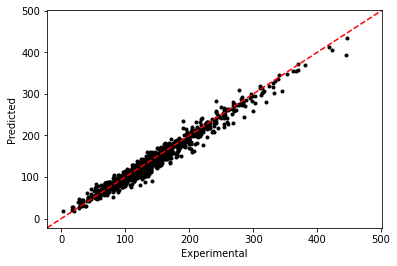

In [11]:
plt.plot(Y,Y_Predicted,'.k')
axes=plt.gca()
# Set x and y limits to the same values
v_min=min(axes.get_ylim()[0],axes.get_xlim()[0])
v_min=v_min-abs(v_min*0.1)
v_max=min(axes.get_ylim()[1],axes.get_xlim()[1])
v_max=v_max+abs(v_max*0.1)
plt.xlim(v_min,v_max)
plt.ylim(v_min,v_max)
plt.xlabel('Experimental')
plt.ylabel('Predicted')
plt.plot([0,1],[0,1],'--r',transform=axes.transAxes)

## Section B

This section allows the user to evaluate the performance of the CNNs developed in this work on a single compound. The code syntax is identical to section A.

Necessary imports:

In [12]:
# General
import os
import pickle

# Specific
import pandas
import numpy
import tensorflow
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt

# Local
from lib import mlAuxiliary as ml

Choose the database code to be evaluated (MM, BP, VP, D, RI, S, D_20, RI_20,S_25) and load the database:

In [13]:
# Database
code='MM' # Change here to MM, BP, VP, D, RI, S, D_20, RI_20, or S_25, as desired.
database=code+'_mlDatabase'
# Build databasePath and load database
databasePath=os.path.join('..','Databases',database+'.csv')
mlDatabase=pandas.read_csv(databasePath,dtype=str)

Choose compound (insert CAS number). If it does not exist on the database selected above, an exception is raised.

In [14]:
CAS='7732-18-5' # Change CAS Number here.
mlDatabase=mlDatabase.loc[mlDatabase['CAS Number']==CAS]
if mlDatabase.empty:
    raise ValueError('CAS Number not found.')

Check wether mlDatabase is of type 1 (no temperature input) or type 2 (temperature input):

In [15]:
if mlDatabase.shape[1]==56: CNN_type=1
elif mlDatabase.shape[1]==57: CNN_type=2

Convert mlDatabase to feature matrix (X) and labels vector (Y):

In [16]:
# Get columns of interest from mlDatabase (drop index, name, CAS, and notes)
A=mlDatabase.iloc[:,3:-1]
# Convert to numpy as float64
A=A.to_numpy(dtype='float64')
# Split into features and labels
if CNN_type==1: # Data does not contain a temperature feature
    X=A[:,1:] # Features
    Y=A[:,0] # Labels
elif CNN_type==2: # Data contains a temperature feature
    Y=A[:,1] # Labels
    X=numpy.delete(A,1,axis=1) # Features

Normalize the feature matrix using the previously trained weights:

In [17]:
#Load feature normalization weights
if CNN_type==1:
    scaler_X=pickle.load(open(os.path.join('..','Models',database+'_X_Scaler.pkl'),'rb'))
elif CNN_type==2:
    scaler_X1=pickle.load(open(os.path.join('..','Models',database+'_X1_Scaler.pkl'),'rb'))
    scaler_X2=pickle.load(open(os.path.join('..','Models',database+'_X2_Scaler.pkl'),'rb'))
# Normalize Features
if CNN_type==1:
    # Normalize all features with Log+bStand
    X=ml.normalize(X,method='Log+bStand',skScaler=scaler_X)[0]
elif CNN_type==2:
    # Normalize sigma profile features with logTransform and temperature feature with Standardization
    X[:,0:1]=ml.normalize(X[:,0:1],method='Standardization',skScaler=scaler_X1)[0]
    X[:,1:]=ml.normalize(X[:,1:],method='Log+bStand',skScaler=scaler_X2)[0]

Reshape X to input into the first convolution layer:

In [18]:
# Reshape for convolution (and for temperature input)
X_Input=X.reshape(X.shape[0],X.shape[1],1)
if CNN_type==2: # Separate temperature feature from sigma profile features
    X_Input=[X_Input[:,1:,0],X_Input[:,0,0]]

Load CNN (tensorflow model saved as .h5 file) and print model summary:

In [19]:
# Load CNN model
modelPath=os.path.join('..','Models',database+'.h5')
model=tensorflow.keras.models.load_model(modelPath)
# Print model summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Layer_0 (InputLayer)         [(None, 51, 1)]           0         
_________________________________________________________________
Layer_1 (Conv1D)             (None, 51, 10)            110       
_________________________________________________________________
Layer_2 (MaxPooling1D)       (None, 51, 2)             0         
_________________________________________________________________
Layer_3 (Conv1D)             (None, 13, 5)             95        
_________________________________________________________________
Layer_4 (AveragePooling1D)   (None, 13, 1)             0         
_________________________________________________________________
Layer_5 (Flatten)            (None, 13)                0         
_________________________________________________________________
Layer_6 (Dense)              (None, 5)                 70    

Use the CNN to make predictions on X:

In [20]:
# Predict
Y_Predicted=model.predict(X_Input)

The predictions are normalized. To compare against the experimental data (Y), they need to be unnormalized using the previously trained weights:

In [21]:
# Load labels normalization weights
scaler_Y=pickle.load(open(os.path.join('..','Models',database+'_Y_Scaler.pkl'),'rb'))
# Set label normalization type
if database=='VP_mlDatabase' or database=='S_mlDatabase' or database=='S_25_mlDatabase':
    labelNorm='LogStand'
else:
    labelNorm='Standardization'
# Unnormalize
Y_Predicted=ml.normalize(Y_Predicted,method=labelNorm,skScaler=scaler_Y,reverse=True)[0]

Print predicted and experimental values.

In [22]:
print('The experimental value is '+str(Y[0]))
print('The predicted value is '+str(Y_Predicted[0,0]))

The experimental value is 18.02
The predicted value is 26.722273
